After some "Notebook Timeouts" I decided to accelerate the prediction loop. The image below shows some common lines which I see a lot in the most notebooks. In the most cases this kind of loop is fast enough but not if you want to use more than one NN model.

In this notebook I want to show, how to improve the first two and the last marked part. The Fillna part was already discussed in [this](https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function) great notebook.

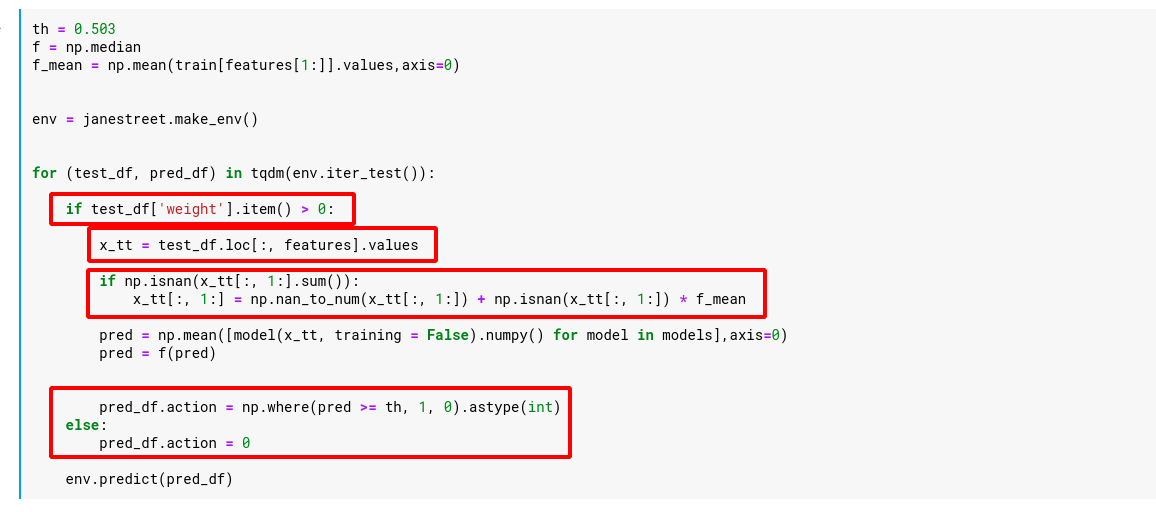

In [ ]:
import numpy as np
from numba import jit, njit
import os
from tqdm import tqdm
import pandas as pd

import janestreet

In [ ]:
train = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv', nrows=100)
train = train.query('date > 85').reset_index(drop = True) 
train = train[train['weight'] != 0]
features_mean = []
features = [c for c in train.columns if 'feature' in c]

for i in features:
    x = train[i].mean()  
    features_mean.append(x)
    train[i] = train[i].fillna(x)
    
train['action'] = ((train['resp'].values) > 0).astype(int)
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']
X_train = train.loc[:, train.columns.str.contains('feature')]
y_train = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T

In [ ]:
th = 0.503
f = np.median
f_mean = np.mean(train[features[1:]].values,axis=0)


env = janestreet.make_env()


for (test_df, pred_df) in tqdm(env.iter_test()):
    
    if test_df['weight'].item() > 0:
        
        x_tt = test_df.loc[:, features].values
        
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        
        pred = np.array([0.50012])
        
        
        pred_df.action = np.where(pred >= th, 1, 0).astype(int)
        break
    else:
        pred_df.action = 0
        
    env.predict(pred_df)

# Weight not 0

In [ ]:
################ SLOW ################
slow = %timeit -o test_df['weight'].item() > 0

In [ ]:
################ FASTER ################
fast = %timeit -o test_df['weight'].values[0] > 0

In [ ]:
print("Accelerated by {:.1f} %".format((1-fast.average/slow.average)*100))

# Get x_tt values

In [ ]:
################ SLOW ################
slow = %timeit -o test_df.loc[:, features].values

In [ ]:
################ FASTER ################
# First you need the numerical index of your features. This has to be done just one time. 
# Notice!! The order in test_df is not the same as in train.

test_df_columns = ['weight'] + [f'feature_{i}' for i in range(130)] + ['date']
features = [c for c in train.columns if 'feature' in c]
index_features = [n for n,col in enumerate(test_df_columns) if col in features]

In [ ]:
fast = %timeit -o test_df.values[0][index_features].reshape(1,-1)

In [ ]:
print("Accelerated by {:.1f} %".format((1-fast.average/slow.average)*100))

# Action
## 1.1 Get Action

In [ ]:
################ SLOW ################
slow = %timeit -o np.where(pred >= th, 1, 0).astype(int)

In [ ]:
################ BETTER ################
%timeit (pred >= th).astype(int)

In [ ]:
################ FASTER ################
fast = %timeit -o int(pred >= th)

In [ ]:
print("Accelerated by {:.1f} %".format((1-fast.average/slow.average)*100))

## 1.2 Declare Action

In [ ]:
################ SLOW ################
slow = %timeit -o pred_df.action = 0

In [ ]:
################ BETTER ################
%timeit pred_df["action"] = 0

In [ ]:
################ FASTER ################
fast = %timeit -o pred_df["action"].values[0] = 0

In [ ]:
print("Accelerated by {:.1f} %".format((1-fast.average/slow.average)*100))